# text-to-speech synthesis demo

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

from synthesizer.inference import Synthesizer
# from dca_synthesizer.inference import Synthesizer
from IPython.display import Audio

import tensorflow as tf 
import numpy as np 
import librosa
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import itertools
import random 
import glob
%matplotlib inline




# Section 1. load resources
## 1.1 load speaker embedding table

In [200]:
# # TRAINSET EMBEDDINGS
EMBASE = 'datasets/best_of_ssb/embeds'
AUDIOBASE = 'datasets/best_of_ssb/audio'
embed_paths = glob.glob(os.path.join(EMBASE, '*'))

def any_embedding() : 
    """returns a random speaker embedding vector"""
    return np.load(
        random.sample(embed_paths, 1)[0]
    )

import re
emb_pattern = re.compile(r'embed-(?P<sid>[A-Z0-9]+)\.wav\.npy')

def any_embedding_with_spk() : 
    """returns a tuple of speaker embedding and its corresponding audio"""
    emb_path = random.sample(embed_paths, 1)[0]
    m = emb_pattern.match(os.path.basename(emb_path))
    a_path = f'audio-{m.group("sid")}.wav.npy'
    
    return np.load(emb_path), np.load(os.path.join(AUDIOBASE, a_path))

def any_embedding_from_spk(spk) : 
    """returns a tuple of speaker embedding and its corresponding audio sample for a given speaker"""
    paths = glob.glob(os.path.join(EMBASE, f'embed-{spk}*'))
    if len(paths) == 0 : 
        raise AssertionError()
    emb_path = random.sample(paths, 1)[0]
    m = emb_pattern.match(os.path.basename(emb_path))
    a_path = f'audio-{m.group("sid")}.wav.npy'
    
    return np.load(emb_path), np.load(os.path.join(AUDIOBASE, a_path))

## 1.2 load tacotron model

In [195]:
ckpt_dir = os.path.join([
    'tf_multispeaker',
    'feedback_synthesizer',
    'saved_models',
    'logs-best_of_ssb_joint_vad_slow_half_l2_v2',
    'taco_pretrained'
])

Synthesizer.hparams.tacotron_num_gpus = 1
Synthesizer.hparams.tacotron_batch_size=1

synthesizer = Synthesizer(Path(ckpt_dir), low_mem=False)

Found synthesizer "best_of_ssb_joint_vad_slow_half_l2_v2" trained to step 1402500


In [8]:
import melgan_archodd
import torch

melgan = melgan_archodd.MelVocoder('tf_multispeaker/melgan_archodd/logs/db1_db4_ljs_finetune')

# mel2audio(mel-spectrogram : ndarray) -> ndarray
# override this to replace vocoder
def mel2audio(mel) : 
    x_t = melgan.inverse(torch.from_numpy(mel)[None]).detach().cpu().numpy()
    return x_t

## 1.3 helper functions for synthesis

In [ ]:
def write_waveform(wav, filename) : 
    librosa.output.write_wav(filename, wav, 16000)

def self_cor(mat) : 
    mode = np.sqrt(np.sum(mat**2, axis=0))[:, None]
    return mat.T @ mat / (mode.T * mode)

def align_measure(attn_mat) : 

    """
    measures an attention map's `correctness`;
    a large value means the attention scores are scattered and incorrect,
    while a small value indicates the alignment tends to form a diagonal-line.

    the measure is length-normalized, but the final silent segments could cause
    the result to raise, but because the model tends to synthesize a constant length
    silent ending segment, this effect could only result in a constant offset from zero
    when comparing among results that are about the same lengths (usually ~ 10)

    preliminary experiments shows : 
        10 usually means good;
        30 means the diagonal trends does exist, but about half of the attetion-map is scatterd
        60 or higher means completely lose focus
    """

    L = attn_mat.shape[0]
    Q = self_cor(attn_mat.T)
    return (np.trace(Q @ Q.T) - L) / L

In [9]:
from cn_convert.phone_convert import transfer_line

def synth_only(txt, emb) : 
    texts = [transfer_line(txt).split('|')[0] for txt in [txt]]
    embed = emb[None]
    
    mel, align = synthesizer.synthesize_spectrograms(texts, embed, return_alignments=True)
    x_t = mel2audio(mel[0])
    
    return x_t[0], align[0], mel[0]

def synth_and_display(txt, emb) : 

    x_t, align, mel = synth_only(txt, emb)
    
    display(Audio(x_t, rate=16000))
    fig, axs = plt.subplots(1,3, figsize=(20,3))
    axs[0].matshow(mel, aspect='auto')
    axs[1].matshow(align, aspect='auto')
    axs[2].plot(x_t)
    
    return x_t, align, mel

# section 2. synthesis demo

In [187]:
long_txt = """
zhe4 li2 % bu3 chong1 % yi2 ge4 % xi4 jie2 $ 
shang4 mian5 de5 % shi4 li4 % zhong1 $ 
bei4 % huan3 cun2 % zhuang1 shi4 qi4 % zhuang1 shi4 de5 % yuan2 han2 shu4 $ 
shi4 yi2 ge4 % wu2 can1 shu4 de4 % han2 shu4 $ 
zhe4 zhong3 % qing2 kuang4 xia4 shi4 % ru2 he2 % gong1 zuo4 de5 % ne1 $

""".replace('\n','')

short_txt = 'neng2 % bu4 neng2 % gao4 su5 wo2 % jie3 fang4 lu4 % zen3 me5 % zou3 $'
# short_txt = 'neng2 bu4 neng2 gao4 su5 wo2 jie3 fang4 lu4 zen3 me5 zou3'
# short_txt = 'wu3 han4 da4 xue2 ji4 suan4 ji1 xue2 yuan4 $'
# short_txt = 'gong1 ji1 jin1 dai4 kuan3 de4 shen1 qing2 zhe3 duo1 wei2 gong1 xin1 jie1 ceng2'
# short_txt = 'zhen1 shi4 mei2 xiang3 dao4 ni3 de5 shu4 xue2 na4 me5 hao3'
# short_txt = 'ni3 % bei4 pan4 $ le5 % gong1 ren2 jie1 jie5'
# short_txt = 'su1 da5 tian1 ran2 kuang4 quan2 shui3'


kefu = 'nin2 hao3 $ hen3 gao1 xing4 % wei4 nin2 % fu2 wu4 $'
kefu = 'hao3 $ qin2 jiang3 $'
kefu = 'zhe4 ge3 % ban4 li3 % kuan1 dai4 de5 % shi2 hou5 % shi4 % liang3 ge5 % shou3 ji1 hao4 ma3 % bang3 ding4 % zai5 % yi4 qi3 % ban4 li3 de5 $'
# short_txt = kefu

align score : 9.94775390625


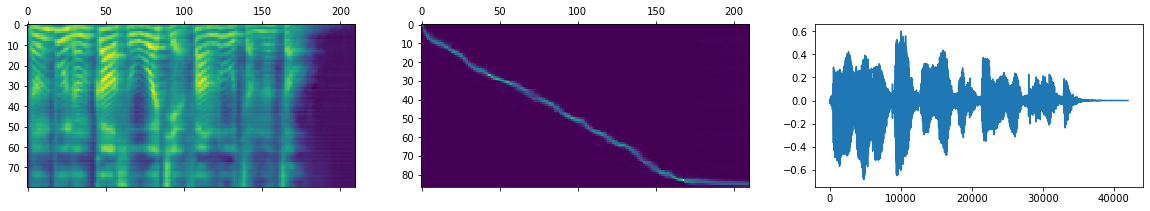

In [229]:
emb, audio = any_embedding_with_spk()
# emb, audio = any_embedding_from_spk('SSB0470')  # trainset

display(Audio(audio, rate=16000))
wav_t, align, _mel = synth_and_display(short_txt, emb)
print(f'align score : {align_measure(align.T)}')